# Human-in-the-loop in agentic architecture
---

### What is multi-Agent Collaboration?
Human-in-the-loop (HITL) in agentic architecture refers to a system design approach where human oversight, intervention, or collaboration is integrated into the AI-driven process. This ensures that AI agents operate within ethical, safe, and effective boundaries, particularly in complex or high-stakes scenarios.

- **Human Oversight & Control**:
Ensures that AI decisions are reviewed, validated, or overridden by humans before execution.
Example: AI suggests business strategies, but executives make the final call.

- **Continuous Learning & Adaptation**:
AI improves over time by learning from human feedback, refining its decision-making process.
Example: Reinforcement Learning with Human Feedback (RLHF) in AI chatbots.

- **Intervention for Critical Decisions**:
In high-risk or complex situations, humans intervene to ensure accuracy and compliance.
Example: In medical AI, doctors approve diagnoses before prescribing treatments.

- **Hybrid Decision-Making**:
AI handles repetitive or high-speed tasks, while humans provide strategic oversight.
Example: AI filters job applications, but recruiters make final hiring decisions.


### Key Advantages
- **Increases Reliability & Trust**:
Reduces AI errors and builds confidence in AI-driven processes.
Ensures decisions are ethical, fair, and compliant with regulations.

- **Enhances Adaptability & Learning**:
AI continuously evolves based on human feedback, improving accuracy and performance.
Avoids rigid automation, allowing AI to adjust to new scenarios.

- **Reduces Risks & Prevents Biases**:
Human intervention helps correct AI biases and prevent unintended consequences.
Especially crucial in AI-driven hiring, medical diagnosis, and financial services.

- **Optimizes Efficiency & Productivity**:
AI accelerates routine tasks, while humans focus on higher-level strategic decisions.
Balances automation with human expertise, leading to better outcomes.

In [15]:
from dotenv import load_dotenv
import os
import json
from azure.core.credentials import AzureKeyCredential
from azure.identity import DefaultAzureCredential
from azure.search.documents import SearchClient
from azure.search.documents.models import VectorizableTextQuery
from azure.ai.evaluation import (
    GroundednessEvaluator,
    RelevanceEvaluator,
    RetrievalEvaluator,
)
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from autogen_core.models import (
    ChatCompletionClient,
    SystemMessage,
    UserMessage,
    LLMMessage,
    AssistantMessage,
)
from autogen_core.tools import FunctionTool, Tool, ToolSchema
from autogen_core.tool_agent import ToolAgent, tool_agent_caller_loop
from autogen_core import (
    AgentId,
    MessageContext,
    RoutedAgent,
    SingleThreadedAgentRuntime,
    TopicId,
    message_handler,
    type_subscription,
)
from pydantic import BaseModel
from typing import List
from dataclasses import dataclass


load_dotenv("../../.env")

True

In [4]:
# Get the environment variables
azure_ai_search_endpoint = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
search_credential = (
    AzureKeyCredential(os.getenv("AZURE_SEARCH_ADMIN_KEY", ""))
    if len(os.getenv("AZURE_SEARCH_ADMIN_KEY", "")) > 0
    else DefaultAzureCredential()
)
index_name = os.getenv("AZURE_SEARCH_INDEX_NAME", "hotels-sample-index")

azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_key = (
    os.getenv("AZURE_OPENAI_API_KEY", "")
    if len(os.getenv("AZURE_OPENAI_API_KEY", "")) > 0
    else None
)
azure_openai_chat_deployment_name = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
azure_openai_embedding_deployment_name = os.getenv(
    "AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME", "text-embedding-ada-002"
)
openai_api_version = os.getenv("OPENAI_API_VERSION", "2024-06-01")

model_config = {
    "azure_endpoint": azure_openai_endpoint,
    "api_key": azure_openai_key,
    "azure_deployment": azure_openai_chat_deployment_name,
    "api_version": openai_api_version,
    "type": "azure_openai",
}

## 🧪 Step 1. Test and Construct each module
---

Before building the entire the graph pipeline, we will test and construct each module separately.

- **HotelRecommendationAgent**
- **UserProxyAgent**
- **HotelReservationAgent**
- **GenerateAgent**
- **UserAgent**

### Construct Retrieval Chain based on PDF
- We use the hotels-sample-index, which can be created in minutes and runs on any search service tier. This index is created by a wizard using built-in sample data.

In [5]:
azure_ai_search_endpoint = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
azure_search_admin_key = os.getenv("AZURE_SEARCH_ADMIN_KEY", "")
search_client = SearchClient(
    endpoint=azure_ai_search_endpoint,
    index_name=index_name,
    credential=AzureKeyCredential(azure_search_admin_key),
    semantic_configuration_name="my-semantic-config",
)

# Query is the question being asked. It's sent to the search engine and the LLM.
query = "Can you recommend a few hotels with complimentary breakfast?"

fields = "descriptionVector"  # TODO: Check if this is the correct field name
# don't use exhaustive search for large indexes
vector_query = VectorizableTextQuery(
    text=query, k_nearest_neighbors=2, fields=fields, exhaustive=True
)

# Search results are created by the search client.
# Search results are composed of the top 3 results and the fields selected from the search index.
# Search results include the top 3 matches to your query.
search_results = search_client.search(
    search_text=query,
    vector_queries=[vector_query],
    select="Description,HotelName,Tags",
    top=3,
)
sources_formatted = "\n".join(
    [
        f'{document["HotelName"]}:{document["Description"]}:{document["Tags"]}'
        for document in search_results
    ]
)

print(sources_formatted)

Lion's Den Inn:Full breakfast buffet for 2 for only $1. Excited to show off our room upgrades, faster high speed WiFi, updated corridors & meeting space. Come relax and enjoy your stay.:['laundry service', 'free wifi', 'restaurant']
Lakefront Captain Inn:Every stay starts with a warm cookie. Amenities like the Counting Sheep sleep experience, our Wake-up glorious breakfast buffet and spacious workout facilities await.:['restaurant', 'laundry service', 'coffee in lobby']
Starlight Suites:Complimentary Airport Shuttle & WiFi. Book Now and save - Spacious All Suite Hotel, Indoor Outdoor Pool, Fitness Center, Florida Green certified, Complimentary Coffee, HDTV:['pool', 'coffee in lobby', 'free wifi']


### Define your LLM

This hands-on only uses the `gpt-4o-mini`, but you can utilize multiple models in the pipeline.

In [6]:
# aoai_client = AzureOpenAI(
#     azure_endpoint=azure_openai_endpoint,
#     api_key=azure_openai_key,
#     api_version=openai_api_version,
# )

# This is not the same object as the one above. This is the client that is used to interact with the Azure OpenAI Chat API.
autogen_aoai_client = AzureOpenAIChatCompletionClient(
    azure_endpoint=azure_openai_endpoint,
    model=azure_openai_chat_deployment_name,
    api_version=openai_api_version,
    api_key=azure_openai_key,
)

### Answer Generator

Construct a LLM Generation node. This is a Naive RAG chain that generates an answer based on the retrieved documents. 

We recommend you to use more advanced RAG chain for production

In [7]:
from pydantic import BaseModel
from typing import List


class HotelInfo(BaseModel):
    hotel_name: str
    description: str


class RecommendationList(BaseModel):
    recommendation: List[HotelInfo]

In [8]:
# This prompt provides instructions to the model
GROUNDED_PROMPT = """
You are a friendly assistant that recommends hotels based on activities and amenities.
Answer the query using only the context provided below in a friendly and concise bulleted manner.
Answer ONLY with the facts listed in the list of context below.
If there isn't enough information below, say you don't know.
Generate a response that includes the top 3 results.
Do not generate answers that don't use the context below.
Query: {query}
Context:\n{context}
"""

# Send the search results and the query to the LLM to generate a response based on the prompt.
response = await autogen_aoai_client.create(
    messages=[
        UserMessage(
            content=GROUNDED_PROMPT.format(query=query, context=sources_formatted),
            source="user",
        ),
    ],
    extra_create_args={"response_format": RecommendationList},
)

response_content = json.loads(response.content)
for recommendation in response_content["recommendation"]:
    print(recommendation)

{'hotel_name': "Lion's Den Inn", 'description': 'Full breakfast buffet for 2 for only $1. Excited to show off our room upgrades, faster high speed WiFi, updated corridors & meeting space.'}
{'hotel_name': 'Lakefront Captain Inn', 'description': 'Every stay starts with a warm cookie. Amenities like the Counting Sheep sleep experience, our Wake-up glorious breakfast buffet and spacious workout facilities await.'}
{'hotel_name': 'Starlight Suites', 'description': 'Complimentary Airport Shuttle & WiFi. Spacious All Suite Hotel, Indoor Outdoor Pool, Fitness Center, Florida Green certified, Complimentary Coffee.'}


<br>

## 🧪 Step 2. Define the Agentic Architecture
- Before building the agentic pipeline, we need to design the message, topic, agent and message routing logic. 
- You should define the terminate condition for the pipeline.

### Message, Topic, Agent Definition

```markdown
```python

# Message Definition
@dataclass
class Message:
    query: str = None
    context: str = None
    response: str = None
    source: str = None

    "HotelRecommendationAgent",
    "GenerateAgent",
    "UserProxyAgent",
    "HotelReservationAgent",
    

# Topic Definition
user_query_topic_type = "HotelRecommendationAgent"
human_in_the_loop_topic_type = "UserProxyAgent"
generate_topic_type = "GenerateAgent"
hotel_reservation_topic_type = "HotelReservationAgent"

# Agent Definition
class HotelRecommendationAgent(RoutedAgent):
class UserProxyAgent(RoutedAgent):
class HotelReservationAgent(RoutedAgent):
class GenerateAgent(RoutedAgent):
class UserAgent(RoutedAgent):


```
```

Visualizing the abstract architecture of the pipeline will help you understand the message flow and the agent's role in the pipeline.

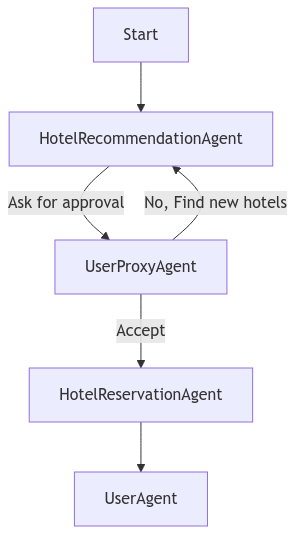

In [20]:
from azure_genai_utils.graphs import visualize_agents

agents = [
    "Start",
    "HotelRecommendationAgent",
    "UserProxyAgent",
    "HotelReservationAgent",
    "UserAgent",
]
interactions = [
    ("Start", "HotelRecommendationAgent"),
    ("HotelRecommendationAgent", "UserProxyAgent", "Ask for approval"),
    ("UserProxyAgent", "HotelReservationAgent", "Accept"),
    ("UserProxyAgent", "HotelRecommendationAgent", "No, Find new hotels"),
    ("HotelReservationAgent", "UserAgent"),
]

visualize_agents(agents, interactions)

In [32]:
@dataclass
class Message:
    query: str = None
    context: str = None
    response: str = None
    source: str = None

    def set_source(self, source: str) -> "Message":
        self.source = source
        return self
        


# Topic Definition
user_query_topic_type = "HotelRecommendationAgent"
human_in_the_loop_topic_type = "UserProxyAgent"
generate_topic_type = "GenerateAgent"
hotel_reservation_topic_type = "HotelReservationAgent"
user_topic_type = "UserAgent"

In [57]:
# This prompt provides instructions to the model
GROUNDED_PROMPT = """
Answer the query using only the context provided below in a friendly and concise bulleted manner.
Answer ONLY with the facts listed in the list of context below.
If there isn't enough information below, say you don't know.
Do not generate answers that don't use the context below.
Query: {query}
Context:\n{context}
"""

@type_subscription(topic_type=user_query_topic_type)
class HotelRecommendationAgent(RoutedAgent):

    def __init__(
        self,
        azure_ai_search_endpoint: str,
        azure_search_admin_key: str,
        index_name: str,
        model_client: ChatCompletionClient,
    ) -> None:

        super().__init__("Hotel Recommendation Agent")
        self.index_name = index_name
        self.azure_ai_search_endpoint = azure_ai_search_endpoint
        self.azure_search_admin_key = azure_search_admin_key
        self._system_message = SystemMessage(
            content=(
                """
                    You are a friendly assistant that recommends hotels based on activities and amenities.
                """
            )
        )
        self._model_client = model_client

    def config_search(self) -> SearchClient:
        service_endpoint = self.azure_ai_search_endpoint
        key = self.azure_search_admin_key
        index_name = self.index_name
        credential = AzureKeyCredential(key)
        return SearchClient(
            endpoint=service_endpoint, index_name=index_name, credential=credential
        )

    async def do_search(self, query: str) -> str:
        """Search indexed data using Azure Cognitive Search with vector-based queries."""
        aia_search_client = self.config_search()

        fields = "descriptionVector"  # TODO: Check if this is the correct field name
        # don't use exhaustive search for large indexes
        vector_query = VectorizableTextQuery(
            text=query, k_nearest_neighbors=1, fields=fields, exhaustive=True
        )

        search_results = aia_search_client.search(
            search_text=query,
            vector_queries=[vector_query],
            select=[
                "Description,HotelName,Tags"
            ],  # TODO: Check if these are the correct field names
            top=3,  # TODO: Check if this is the correct number of results
        )
        answer = "\n".join(
            [
                f'{document["HotelName"]}:{document["Description"]}:{document["Tags"]}'
                for document in search_results
            ]
        )
        return answer

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        print(f"\n{'-'*80}\n{self.id.type} received a message:\n")
        context_from_ai_search = await self.do_search(message.query)
        print(context_from_ai_search)

        llm_result = await self._model_client.create(
            messages=[
                self._system_message,
                UserMessage(
                    content=GROUNDED_PROMPT.format(
                        query=message.query, context=context_from_ai_search
                    ),
                    source=message.source,
                ),
            ],
            extra_create_args={"response_format": RecommendationList},
            cancellation_token=ctx.cancellation_token,
        )

        response = llm_result.content

        print(response)

        await self.publish_message(
            Message(
                query=query, context=context_from_ai_search, response=response, source=message.source
            ),
            topic_id=TopicId(type=human_in_the_loop_topic_type, source=message.source),
        )

    

In [58]:
@type_subscription(topic_type=human_in_the_loop_topic_type)
class HumanInTheLoopAgent(RoutedAgent):
    def __init__(self) -> None:
        super().__init__("Human in the loop Agent")

    @message_handler
    async def handle_user_input(self, message: Message, ctx: MessageContext) -> None:
        print(f"\n{'-'*80}\n{self.id.type} received a message:\n")
        message = message.set_source(self.id.key)

        human_input = input("Human input (Accept / No): ")
        print(f"{'-'*80}\n{self.id.type}:\n{human_input}", flush=True)

        if human_input.lower() == "accept":
            await self.publish_message(
                message,
                topic_id=TopicId(hotel_reservation_topic_type, source=self.id.key),
            )
        elif human_input.lower() == "no":
            revised_query = input("Please input a more specific question to get new hotel recommendations: ")
            print(f"{'-'*80}\n{self.id.type}:\n{human_input}", flush=True)
            await self.publish_message(
                Message(
                    query=revised_query,
                    context=None,
                    response=None,
                    source=message.source,
                ),
                topic_id=TopicId(user_query_topic_type, source=self.id.key),
            )

In [95]:
@type_subscription(topic_type=hotel_reservation_topic_type)
class HotelReservationUseAgent(RoutedAgent):
    def __init__(self, model_client: ChatCompletionClient, tool_schema: List[ToolSchema], tool_agent_type: str) -> None:
        super().__init__("Use tools to solve tasks.")
        self._model_client = model_client
        self._system_message = SystemMessage(
            content=(
                """
                You are a tool usage agent who can delegate your task to the ToolAgent.
                """
            )
        )
        self._tool_schema = tool_schema
        self._tool_agent_id = AgentId(tool_agent_type, self.id.key)

    @message_handler
    async def handle_tool(self, message: Message, ctx: MessageContext) -> None:
        print(f"\n{'-'*80}\n{self.id.type} received a message:\n")
        # Create a session of messages.
        hotel_list = json.loads(message.response)["recommendation"]
        for hotel in hotel_list:
            print(hotel)
        
        session: List[LLMMessage] = [AssistantMessage(content=message.response, source=self.id.key)]
        # Run the caller loop to handle tool calls.
        messages = await tool_agent_caller_loop(
            self,
            tool_agent_id=self._tool_agent_id,
            model_client=self._model_client,
            input_messages=session,
            tool_schema=self._tool_schema,
            cancellation_token=ctx.cancellation_token,
        )

        assert isinstance(messages[-1].content, str)
        await self.publish_message(AssistantMessage(content=messages[-1].content, source=self.id.key), topic_id=TopicId(type=user_topic_type, source=self.id.key))            

In [96]:
@type_subscription(topic_type=user_topic_type)
class UserAgent(RoutedAgent):
    def __init__(self) -> None:
        super().__init__("A user agent that outputs the final copy to the user.")

    @message_handler
    async def handle_final_copy(
        self, message: AssistantMessage, ctx: MessageContext
    ) -> None:
        print(f"\n{'-'*80}\n{self.id.type} received final copy:\n{message.content}")

<br>

## 🧪 Step 3. Execute the Workflow
---

### Execute the workflow

In [97]:
runtime = SingleThreadedAgentRuntime()

await HotelRecommendationAgent.register(
    runtime,
    type=user_query_topic_type,
    factory=lambda: HotelRecommendationAgent(
        azure_ai_search_endpoint=azure_ai_search_endpoint,
        azure_search_admin_key=azure_search_admin_key,
        index_name=index_name,
        model_client=autogen_aoai_client,
    ),
)

await HumanInTheLoopAgent.register(
    runtime,
    type=human_in_the_loop_topic_type,
    factory=lambda: HumanInTheLoopAgent(),
)

def call_hotel_reservation(message: Message) -> str:
    return "Hotel reservation completed."

tools: List[Tool] = [FunctionTool(call_hotel_reservation, description="make a hotel reservation")]

await HotelReservationUseAgent.register(
    runtime,
    type=hotel_reservation_topic_type,
    factory=lambda: HotelReservationUseAgent(autogen_aoai_client, [tool.schema for tool in tools], "tool_executor_agent"))

await ToolAgent.register(runtime, "tool_executor_agent", lambda: ToolAgent("tool executor agent", tools))

await UserAgent.register(runtime, type=user_topic_type, factory=lambda: UserAgent())

AgentType(type='UserAgent')

In [99]:
import time

start_time = time.perf_counter()

runtime.start()
await runtime.publish_message(
    Message(
        query="Can you recommend hotels and make a reservation with the one of best hotels with complimentary breakfast?",
        source="User",
    ),
    topic_id=TopicId(type=user_query_topic_type, source="user"),
)
await runtime.stop_when_idle()

end_time = time.perf_counter()
print(f"Elapsed time: {end_time - start_time} seconds")


--------------------------------------------------------------------------------
HotelRecommendationAgent received a message:



Thunderbird Motel:Book Now & Save. Clean, Comfortable rooms at the lowest price. Enjoy complimentary coffee and tea in common areas.:['coffee in lobby', 'free parking', 'free wifi']
Double Sanctuary Resort:5 star Luxury Hotel - Biggest Rooms in the city. #1 Hotel in the area listed by Traveler magazine. Free WiFi, Flexible check in/out, Fitness Center & espresso in room.:['view', 'pool', 'restaurant', 'bar', 'continental breakfast']
Starlight Suites:Complimentary Airport Shuttle & WiFi. Book Now and save - Spacious All Suite Hotel, Indoor Outdoor Pool, Fitness Center, Florida Green certified, Complimentary Coffee, HDTV:['pool', 'coffee in lobby', 'free wifi']
{"recommendation":[{"hotel_name":"Double Sanctuary Resort","description":"5 star Luxury Hotel - Biggest Rooms in the city. #1 Hotel in the area listed by Traveler magazine. Free WiFi, Flexible check in/out, Fitness Center & espresso in room. Includes continental breakfast."}]}

-----------------------------------------------------